# **RECCAP Plots**

In [1]:
import numpy as np
import glob
import os
from cdo import Cdo
import sys
import subprocess as sp
import intake
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import pandas as pd
from tqdm import tqdm 
import xarray as xr
import pandas
import re

import warnings

import plotting_helpers as ph

sys.path.append("/home/u/u301557/UHH-CMIP6/scripts")
from functions.FUNC_CreateModellist import MODELLIST
from functions.FUNC_CreateModellist import MODELLIST_from_list

sys.path.append("/home/u/u301557/UHH-Sat-SIA/scripts")
from functions.logger_functions import *

cdo = Cdo()
#os.system('module load nco')
#os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

print("DONE")

DONE


In [2]:
outpath        = f"/work/uo1227/u301557/ArcticCarbon/data/"            # test outpath

#gridpath       = '/work/uo1227/DATA/modelling/CMIP6/gridareas/'                   # where the gridarea files are strored
gridpath       = '/work/uo1227/u301557/ArcticCarbon/data/gridarea/'
temppath       = '/work/uo1227/u301557/temp/'                                     # temporary strorage for "mergetime"    
ocean_maskpath = "/work/uo1227/u301557/ArcticCarbon/data/ocean-masks-remap/"
AO_mask        = "/home/u/u301557/ArcticCarbon/Arctic_ocean_mask_regions.nc"

## Fig.4: Global - cVeg, cSoil, NBP, fgco2

<img src="./figures/RECCAPP-Fig4.png" alt="drawing" width="900"/>

In [3]:
def modellist_from_files(files, split_chr="_", split_num=-3):
    modellist = []
    for file in files:
        model = file.split(split_chr)[split_num]
        modellist.append(model)
    return list(set(modellist))
        

In [4]:
files = sorted(glob.glob(outpath + f"*/*glob*.nc"))
modellist = modellist_from_files(files)
print(len(modellist))
modellist = sorted(modellist)
print(len(modellist))

37
37


In [5]:
colors = pl.cm.twilight_r(np.linspace(0,1,len(modellist)))
model_colors = dict.fromkeys(modellist)
for cnt, model in enumerate(modellist):
    model_colors[model] = colors[cnt]

In [6]:
var = "cVeg"
scenario = "ssp126"
files = sorted(glob.glob(outpath + f"{var}/{var}*glob*{scenario}.nc"))

def file_to_dataframe(files, var):
    
    if scenario == "historical":
        years = np.arange(1850, 2015)
        start_date = pd.to_datetime('1850-01-01')
        end_date = pd.to_datetime('2014-12-31')
    else:
        years = np.arange(2015, 2101)
        start_date = pd.to_datetime('2015-01-01')
        end_date = pd.to_datetime('2100-12-31')
    
    df = pd.DataFrame({"year":years})
    df = df.set_index("year")
    
    #print(files)
    for file in files:
        try:
            model = file.split("/")[-1].split("_")[-3]
            member = file.split("/")[-1].split("_")[-2]
            
            ds = xr.open_dataset(file)
            # Create a datetime object representing the end date (2100)
            ds['time'] = ds.time.values.astype('datetime64[ns]')
            
            #ds['time'] = ds['time'].dt.to_datetime64(calendar='gregorian')
            # Slice the data based on the end date
            sliced_ds = ds.where(ds.time <= end_date, drop=True)
            sliced_ds = sliced_ds.where(sliced_ds.time >= start_date, drop=True)
            sliced_ds['time'] = sliced_ds.time.dt.year.values.astype('int')
            df_model = pd.DataFrame({"year":sliced_ds['time'].values})#sliced_ds['time'].values})
            df_model = df_model.set_index("year")
            df_model[model] = sliced_ds[var].values.squeeze()
            #df[model] = sliced_ds[var].values
            df = df.join(df_model, how='left', rsuffix=f'_{member}')
            nan_count = df[model].isnull().sum()
            if nan_count > 5:
                df = df.drop(model, axis=1)

            elif not number_check(df[model]):
                df = df.drop(model, axis=1)
                print(model, var, scenario, "didnt pass number check")
            
            ds.close()
        except Exception as e:
            print(model, e, sliced_ds[var].values.shape, sliced_ds.time.values[:2], sliced_ds.time.values[-2:])
    
    return df

In [7]:
def number_check(array):
    in_range = True
    if np.nanmax(array) > 10000:
        in_range = False
    if np.nanmin(array) < -20:
        in_range = False
    
    return in_range

In [8]:
DF = {}

for var in ["cVeg", "cSoil", "nbp", "fgco2"]:#]):
    #print(var)
    DF[var] = {}
    for scenario in ["historical", "ssp126", "ssp370"][:]:
        #print(scenario)
        files = sorted(glob.glob(outpath + f"{var}/{var}*glob*{scenario}.nc"))
        DF[var][scenario] = file_to_dataframe(files, var)

E3SM-1-1-ECA cVeg historical didnt pass number check
E3SM-1-1 cVeg historical didnt pass number check


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.

E3SM-1-1-ECA nbp historical didnt pass number check
E3SM-1-1 nbp historical didnt pass number check
GISS-E2-1-G nbp historical didnt pass number check
GISS-E2-1-H nbp historical didnt pass number check
NorCPM1 nbp historical didnt pass number check


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.

GISS-E2-1-G nbp ssp370 didnt pass number check


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.

In [9]:
cVeg_Soil_1850  = {}
cVeg_Soil_1850["cVeg"] = {}
cVeg_Soil_1850["cSoil"] = {}
for var in ["cVeg", "cSoil"]:
    print(var)
    for scenario in ["historical", "ssp126", "ssp370"]:
        print(scenario)
        for model in DF[var][scenario].columns:
            try:
                if scenario == "historical":
                    cVeg_Soil_1850[var][model] = DF[var][scenario].iloc[0][model]
                
                DF[var][scenario][model] = DF[var][scenario][model] - cVeg_Soil_1850[var][model]
            except Exception as e:
                print(e)

cVeg
historical
ssp126
ssp370
cSoil
historical
ssp126
ssp370
'CanESM5_r1i1p2f1'


'CanESM5_r1i1p2f1'
'CanESM5_r1i1p2f1'
'CanESM5_r1i1p2f1'
'CanESM5_r1i1p2f1'
'CanESM5_r1i1p2f1'
'CanESM5_r1i1p2f1'


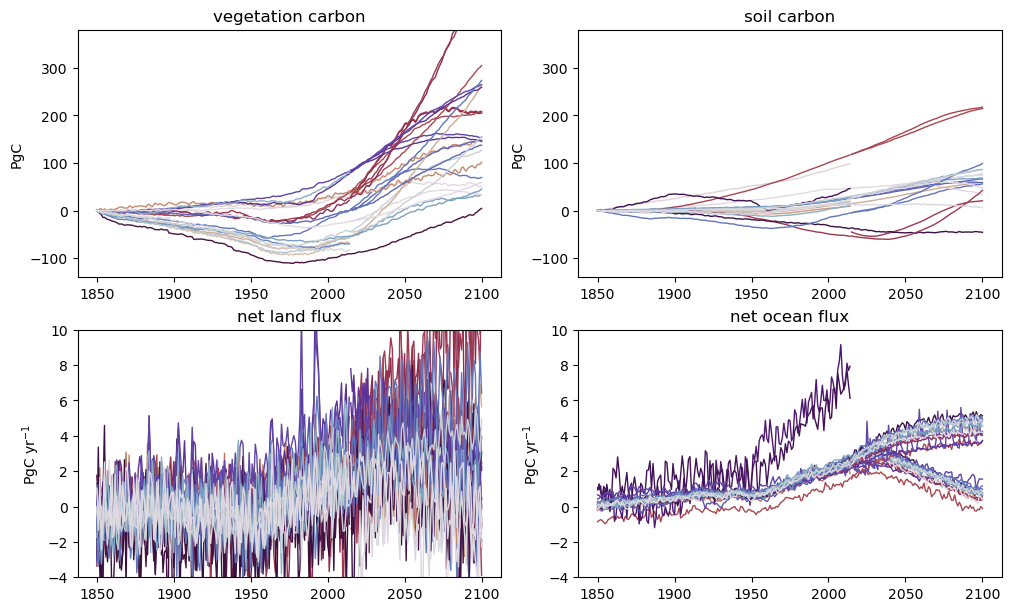

In [10]:
fig, axs = plt.subplots(2,2, figsize=(10,6), constrained_layout=True)#tight_layout=True, 

cVeg_Soil_1850  = {}
cVeg_Soil_1850["cVeg"] = {}
cVeg_Soil_1850["cSoil"] = {}

color_code = "models" # models scenarios

cc_ssps   = {"ssp119" :"#00a9cf",
             "ssp126" :"#003466",
             "ssp245" :"#f69320",
             "ssp370" :"#df0000",
             "ssp585" :"#980002", 
             "historical":"dimgray"}

names = {"cVeg":"vegetation carbon", "cSoil":"soil carbon", "nbp":"net land flux", "fgco2":"net ocean flux"}

for ax,var in zip(axs.flatten(),["cVeg", "cSoil", "nbp", "fgco2"]):#]):
    ax.set_title(names[var])
    for scenario in ["historical", "ssp126", "ssp370"]:
        for model in DF[var][scenario].columns:
            if model == "NorCPM1":
                pass
            else:
                try:
                    if color_code == "models":
                        color = model_colors[model]
                        lw = 1
                        alpha=1
                    else:
                        color = cc_ssps[scenario]
                        lw = 0.5
                        alpha=0.3
                        
                    ax.plot(DF[var][scenario].index, DF[var][scenario][model], color=color, lw=lw, alpha=alpha)
                except Exception as e:
                    print(e)
        if color_code == "scenarios":
            mean = DF[var][scenario].mean(axis=1)
            std = DF[var][scenario].std(axis=1)
            #ax.plot(mean, color=color)
            #ax.fill_between(DF[var][scenario].index, mean-std, mean+std, color=color, alpha=0.3)
for ax in axs[0,:]:
    ax.set_ylabel("PgC")
    ax.set_ylim(-140,380)
for ax in axs[1,:]:
    ax.set_ylabel("PgC yr$^{-1}$")
    ax.set_ylim(-4,10)

## "Tables"

<img src="./figures/RECCAP-Tab11.png" alt="drawing" width="900"/>

In [11]:
def files_to_dataframe(files, var):
    years = np.arange(1850, 2015)
    df = pd.DataFrame({"year":years})#
    
    for file in files:
        try:
            model = file.split("/")[-1].split("_")[-3]
            ds = xr.open_dataset(file)
            df[model] = ds[var].values
            ds.close()
        except Exception as e:
            print(e)
    
    df = df.set_index("year")

    return df

In [12]:
DF_60 = {}
scenario = "historical"
for var in ["gpp", "npp", "nep", "nbp","fgco2", "fLuc", "cVeg", "cSoil", "terra_carbon"]:#]):
    #print(var)
    #DF_60[var] = {}
    #for scenario in ["historical", "ssp126", "ssp370"][:]:
        #print(scenario)
        files = sorted(glob.glob(outpath + f"{var}/{var}*N60*{scenario}.nc"))
        print(var, len(files))
        DF_60[var] = file_to_dataframe(files, var)

gpp 24
npp 26
nep 16
nbp 33
E3SM-1-1-ECA nbp historical didnt pass number check
E3SM-1-1 nbp historical didnt pass number check
GISS-E2-1-G nbp historical didnt pass number check
GISS-E2-1-H nbp historical didnt pass number check
fgco2 27
fLuc 13
cVeg 27
E3SM-1-1-ECA cVeg historical didnt pass number check
E3SM-1-1 cVeg historical didnt pass number check
cSoil 20
terra_carbon 19


24
'GISS-E2-1-G_r1i1p1f2'
gpp: mean=5.92, std=2.13
26
'GISS-E2-1-G_r1i1p1f2'
npp: mean=3.44, std=1.87
16
nep: mean=0.27, std=0.20
33
'CanESM5_r1i1p2f1'
nbp: mean=0.20, std=0.19
27
'CanESM5_r1i1p2f1'
fgco2: mean=0.32, std=0.19
13
fLuc: mean=0.02, std=0.02


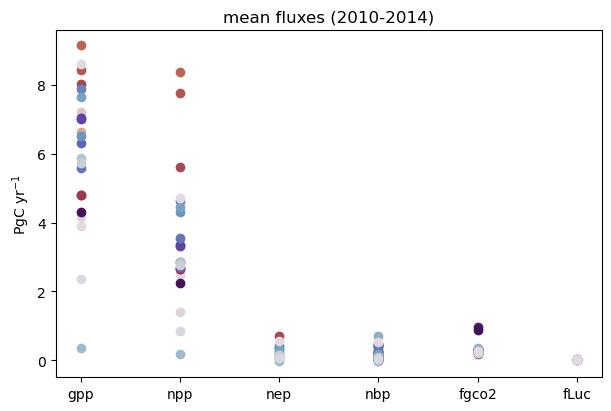

In [13]:
variables = ["gpp", "npp", "nep", "nbp","fgco2", "fLuc"]#, "cVeg", "cSoil", "terra_carbon"
fig, ax = plt.subplots(1,1, figsize=(6,4), constrained_layout=True)#tight_layout=True, 

for i,var in enumerate(variables):#, "npp", "rh","ra"]):
    files_60 = sorted(glob.glob(outpath + f"{var}/{var}*N60*historical.nc"))
    print(len(files_60))
    df_60 = DF_60[var].copy()
    for model, value in df_60.loc[2010:2014].mean(axis=0).items():
        if value > 50:
            print(model)
        elif value < -50:
            print(model)
        else:
            try:
                ax.scatter(i, value, color=model_colors[model])
            except Exception as e:
                print(e)
        
    print(f"{var}: mean={df_60.loc[2010:2014].mean(axis=0).mean():1.2f}, std={df_60.loc[2010:2014].mean(axis=0).std():1.2f}")
ax.set_xticks(range(len(variables)), variables)
ax.set_title("mean fluxes (2010-2014)")
ax.set_ylabel("PgC yr$^{-1}$")
plt.show()
#plt.ylim(-1,6)

27
'CanESM5_r1i1p2f1'
cVeg: mean=27.77, std=14.05
20
cSoil: mean=452.24, std=551.96
19
terra_carbon: mean=476.84, std=571.41


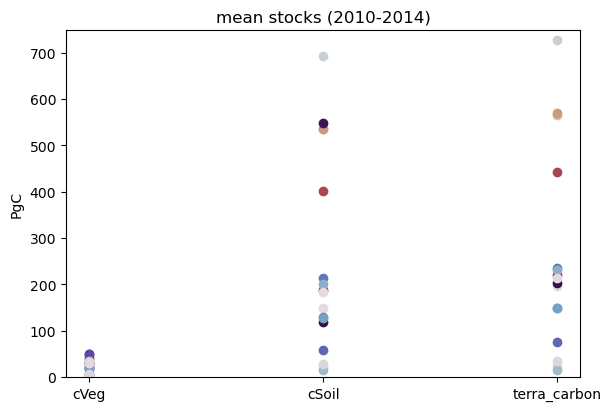

In [15]:
variables = ["cVeg", "cSoil", "terra_carbon"]#, "cVeg", "cSoil", "terra_carbon"
fig, ax = plt.subplots(1,1, figsize=(6,4), constrained_layout=True)#tight_layout=True, 

for i,var in enumerate(variables):#, "npp", "rh","ra"]):
    files_60 = sorted(glob.glob(outpath + f"{var}/{var}*N60*historical.nc"))
    print(len(files_60))
    df_60 = DF_60[var].copy()
    for model, value in df_60.loc[2010:2014].mean(axis=0).items():
        if value > 10000:
            print(model)
        elif value < 0:
            print(model)
        else:
            try:
                ax.scatter(i, value, color=model_colors[model])
            except Exception as e:
                print(e)
        
    print(f"{var}: mean={df_60.loc[2010:2014].mean(axis=0).mean():1.2f}, std={df_60.loc[2010:2014].mean(axis=0).std():1.2f}")
ax.set_xticks(range(len(variables)), variables)
ax.set_title("mean stocks (2010-2014)")
ax.set_ylabel("PgC")
ax.set_ylim(0,750)
plt.show()

## Regional: GPP, NBP, Terrestrial Carbon

<img src="./figures/RECCAP-Fig18.png" alt="drawing" width="900"/>

In [89]:
DF = {}
scenario = "historical"
for var in ["gpp", "nbp", "terra_carbon"]:#]):
    #print(var)
    DF[var] = {}
    for scenario in ["historical", "ssp126", "ssp370"][:]:
        #print(scenario)
        files = sorted(glob.glob(outpath + f"{var}/{var}*N60*{scenario}.nc"))
        print(var, len(files))
        DF[var][scenario] = file_to_dataframe(files, var)

gpp 24
gpp 11
gpp 17


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.

nbp 33
E3SM-1-1-ECA nbp historical didnt pass number check
E3SM-1-1 nbp historical didnt pass number check
GISS-E2-1-G nbp historical didnt pass number check
GISS-E2-1-H nbp historical didnt pass number check
nbp 15


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.

nbp 19
GISS-E2-1-G nbp ssp370 didnt pass number check
terra_carbon 19
terra_carbon 6
terra_carbon 12


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.

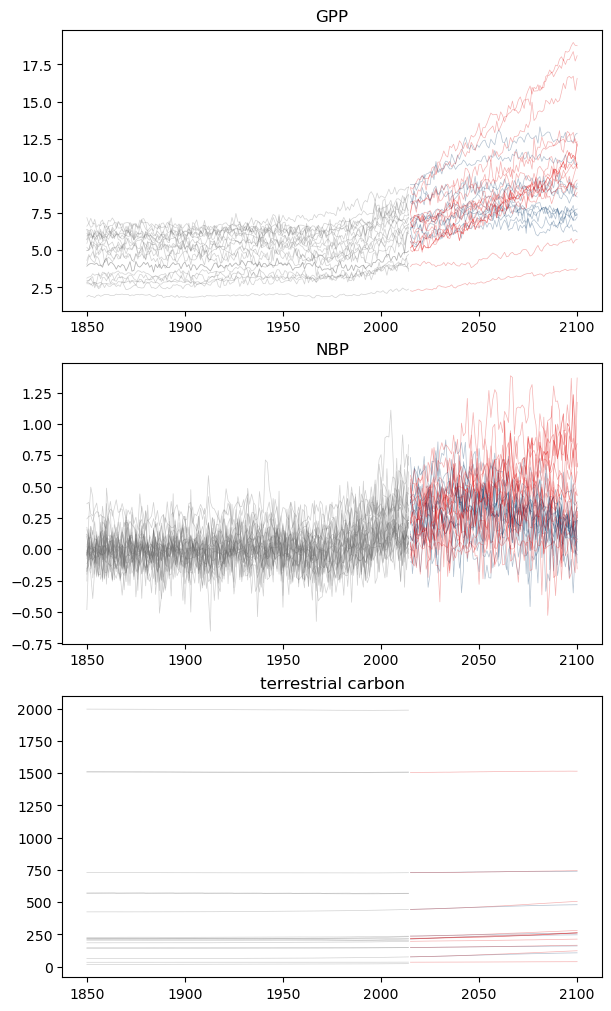

In [90]:
fig, axs = plt.subplots(3,1, figsize=(6,10), constrained_layout=True)#tight_layout=True, 

cVeg_Soil_1850  = {}
cVeg_Soil_1850["cVeg"] = {}
cVeg_Soil_1850["cSoil"] = {}

color_code = "scenarios" # models scenarios

cc_ssps   = {"ssp119" :"#00a9cf",
             "ssp126" :"#003466",
             "ssp245" :"#f69320",
             "ssp370" :"#df0000",
             "ssp585" :"#980002", 
             "historical":"dimgray"}

names = {"gpp":"GPP", "terra_carbon":"terrestrial carbon","cVeg":"vegetation carbon", "cSoil":"soil carbon", "nbp":"NBP", "fgco2":"net ocean flux"}

for ax,var in zip(axs.flatten(),["gpp", "nbp", "terra_carbon"]):#]):
    ax.set_title(names[var])
    for scenario in ["historical", "ssp126", "ssp370"]:
        for model in DF[var][scenario].columns:
            if model == "NorCPM1":
                pass
            else:
                try:
                    if color_code == "models":
                        color = model_colors[model]
                        lw = 1
                        alpha=1
                    else:
                        color = cc_ssps[scenario]
                        lw = 0.5
                        alpha=0.3
                        
                    ax.plot(DF[var][scenario].index, DF[var][scenario][model], color=color, lw=lw, alpha=alpha)
                except Exception as e:
                    print(e)
        if color_code == "scenarios":
            mean = DF[var][scenario].mean(axis=1)
            std = DF[var][scenario].std(axis=1)
            #ax.plot(mean, color=color)
            #ax.fill_between(DF[var][scenario].index, mean-std, mean+std, color=color, alpha=0.3)
#for ax in axs[0,:]:
#    ax.set_ylabel("PgC")
#    ax.set_ylim(-140,380)
#for ax in axs[1,:]:
#    ax.set_ylabel("PgC yr$^{-1}$")
#    ax.set_ylim(-4,10)